In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import copy
import math

from sklearn.model_selection import train_test_split
from hmmlearn import hmm

np.random.seed(46)

In [111]:
# sample sequences parameters
sequenceLen = 100 # e.g. O = [1, 2, 3] => sampleLen = 3
nSequencesTrain = 50 # only use normal samples for training
nSequencesNormalTest = 50
nSequencesAnomalyTest = 50

# synthetic parameters
peakMean = 10
peakSD = 1 # SD := standard deviation
noBeatPos = 0 # the position when the heart does not beat
noiseMean = 0
noiseSD = 1

period = 20
positivePeakID1 = 1
positivePeakID2 = 2
negativePeakID1 = 4
negativePeakID2 = 5

In [112]:
# generate the training set
dataTrain = np.zeros((nSequencesTrain * sequenceLen,))
dataTrainLen = np.zeros((nSequencesTrain,), dtype = 'int')
for i in range(nSequencesTrain):
    peak = np.random.normal(loc = peakMean, scale = peakSD,
                            size = 1) # one sequence has the same ppk
    for j in range(sequenceLen):
        if (j % period == positivePeakID1 
            or j % period == positivePeakID2):
            observation = peak
        elif (j % period == negativePeakID1
              or j % period == negativePeakID2):
            observation = - peak
        else:
            observation = noBeatPos
        noise = np.random.normal(loc = noiseMean,
                            scale = noiseSD,
                            size = 1)
        observation = observation + noise
        dataTrain[i * sequenceLen + j] = observation
    dataTrainLen[i] = int(sequenceLen)

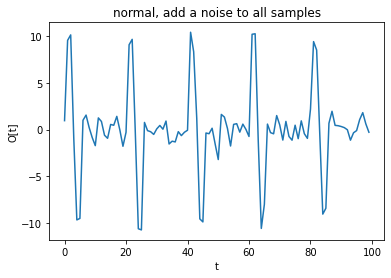

In [113]:
# training (normal) set demo
plt.plot(dataTrain[0 : sequenceLen])
plt.title('normal, add a noise to all samples')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()

In [114]:
# generate the normal testing set
normalTest = np.zeros((nSequencesNormalTest * sequenceLen,))
normalTestLen = np.zeros((nSequencesNormalTest,), dtype = 'int')
for i in range(nSequencesNormalTest):
    peak = np.random.normal(loc = peakMean, scale = peakSD, size = 1)
    for j in range(sequenceLen):
        if (j % period == positivePeakID1 
            or j % period == positivePeakID2):
            observation = peak
        elif j % period == negativePeakID:
            observation = - peak
        else:
            observation = noBeatPos
        # add a noise to the observation
        noise = np.random.normal(loc = noiseMean,
                            scale = noiseSD,
                            size = 1)
        observation = observation + noise
        normalTest[i * sequenceLen + j] = observation
    normalTestLen[i] = int(sequenceLen)
        
# generate one anomaly testing set
# this anomaly set sometimes has a different period
anomalyTest = np.zeros((nSequencesAnomalyTest * sequenceLen,))
anomalyTestLen = np.zeros((nSequencesAnomalyTest,), dtype = 'int')
nAnomaly = 2 # number of times that the heart suddenly jumps
magicCnt = 8
positiveMagicID1 = 6
positiveMagicID2 = 7
negativeMagicID1 = 9
negativeMagicID2 = 10
for i in range(nSequencesAnomalyTest):
    peak = np.random.normal(loc = peakMean, scale = peakSD, size = 1)
    magicCnt = 3
    for j in range(sequenceLen):
        if (j % period == positivePeakID1 
            or j % period == positivePeakID2): # normal beat
            observation = peak
            magicCnt = magicCnt - 1
        elif (j % period == negativePeakID1
              or j % period == negativePeakID2): # normal beat
            observation = - peak
        else:
            if magicCnt <= 0 and magicCnt > - nAnomaly:
                # magic influences the patient's heart!
                if (j % period == positiveMagicID1
                    or j % period == positiveMagicID2):
                    observation = peak
                elif (j % period == negativeMagicID1
                      or j % period == negativeMagicID2):
                    observation = - peak
                else:
                    observation = noBeatPos
            else:
                # beats normally
                observation = noBeatPos
        # add a noise
        noise = np.random.normal(loc = noiseMean,
                            scale = noiseSD,
                            size = 1)
        observation = observation + noise
        anomalyTest[i * sequenceLen + j] = observation
    anomalyTestLen[i] = int(sequenceLen)

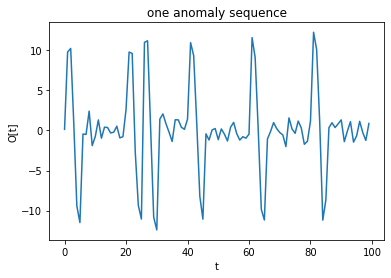

In [115]:
# anomaly set demo
plt.plot(anomalyTest[0 : sequenceLen])
plt.title('one anomaly sequence')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()

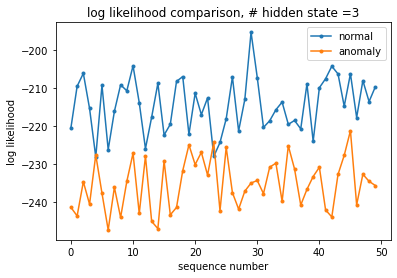

In [116]:
# model parameters
nComponents = 3

# define a left to right model
model = hmm.GaussianHMM(n_components = nComponents,
                        covariance_type = "full",
                        init_params='smcw')
transMat = np.zeros((nComponents, nComponents))
for i in range(len(transMat)):
    for j in range(len(transMat[i])):
        if j == i or j == i + 1:
            transMat[i][j] = 0.5
transMat[nComponents - 1][0] = 0.5
model.transmat_ = transMat

# train the model using only the normal dataset
dataFit = dataTrain.reshape(-1, 1)
model.fit(dataFit, dataTrainLen)

# test the model

# use the normal test set
scoreNormal = np.empty((nSequencesNormalTest, ))
for i in range(nSequencesNormalTest):
    dataScore = normalTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreNormal[i] = model.score(dataScore)

# use the special test set
scoreAnomaly = np.empty((nSequencesAnomalyTest, ))
for i in range(nSequencesNormalTest):
    dataScore = anomalyTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreAnomaly[i] = model.score(dataScore)

# plot the testing result
plt.plot(scoreNormal, ".-", label = 'normal')
plt.plot(scoreAnomaly, ".-", label = 'anomaly')
plt.legend()
plt.title('log likelihood comparison, # hidden state =' +
          str(nComponents))
plt.xlabel('sequence number')
plt.ylabel('log likelihood')
plt.show()